This notebook is used to create supplemental plots for Figure 4.

* gap statistic
* correlation within cluster
* UMAP
* n mice per cluster and vice versa (need to transfer from shuffle notebook



In [1]:
import os
import numpy as np

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import seaborn as sns

sns.set_context('notebook', font_scale=1, rc={'lines.markeredgewidth': 1})



In [2]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_clustering as glm_clust

palette_experience = utils.get_experience_level_colors()
palette_cre = utils.get_cre_line_colors()

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [6]:

# # load experiments table
experiments_table = loading.get_platform_paper_experiment_table()
# # limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
3921 cells in matched cells table


In [7]:
palette = utils.get_cre_line_colors()


### Set up variables and stuff

In [8]:
threshold=0.1

In [9]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [10]:
# set params for saving
folder = '240101_SSE_general'
file_dir = '240101_shuffle_test'

In [15]:
base_dir = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, 'all_cre_clustering_082823_n_14')
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [12]:
# create folder to load and save to
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

#### Load original feature matrix, meta data and cluster labels

In [16]:
filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
all_feature_matrix = pd.read_hdf(os.path.join(base_dir, filename), key='df')

In [17]:
filename = 'cluster_meta_n_14_clusters.h5'
df_meta = pd.read_hdf(os.path.join(base_dir, filename))

In [19]:
original_cluster_labels = df_meta.copy()
original_cluster_labels['cluster_id'] = original_cluster_labels['cluster_id'].copy()+1


In [20]:
# trying to fix mismatch of clusters 4 and 5

indices = original_cluster_labels[original_cluster_labels['cre_line']=='Slc17a7-IRES2-Cre'].index.values
original_cluster_labels.loc[indices, 'cluster_id']=original_cluster_labels[original_cluster_labels['cre_line']=='Slc17a7-IRES2-Cre']['cluster_id'].replace([4,5], [5,4])
original_cluster_labels

,cell_specimen_id,ophys_experiment_id,cre_line,cluster_id,labels,within_cluster_correlation
0,1086489847,1003771765,Vip-IRES-Cre,9,1,0.477738
1,1086489860,1003771765,Vip-IRES-Cre,2,5,0.532181
2,1086489891,1003771765,Vip-IRES-Cre,9,1,0.638229
3,1086489976,962471831,Sst-IRES-Cre,4,9,0.480384
4,1086490002,962471831,Sst-IRES-Cre,4,9,0.761853
...,...,...,...,...,...,...
3896,1120133342,1086707474,Slc17a7-IRES2-Cre,1,4,NaN
3897,1120133375,1086707474,Slc17a7-IRES2-Cre,2,5,0.541558
3898,1120133471,1086707474,Slc17a7-IRES2-Cre,5,9,0.550737
3899,1120133515,1086707474,Slc17a7-IRES2-Cre,3,7,0.532379


In [23]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line].cell_specimen_id.values
    df_cre = all_feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

#### compute mean dropout scores for original data

In [25]:
cre_mean_dropout_scores = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = df_meta[df_meta.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df, sort= False, max_n_clusters=12)
    cre_mean_dropout_scores[cre_line] = mean_dropout_scores

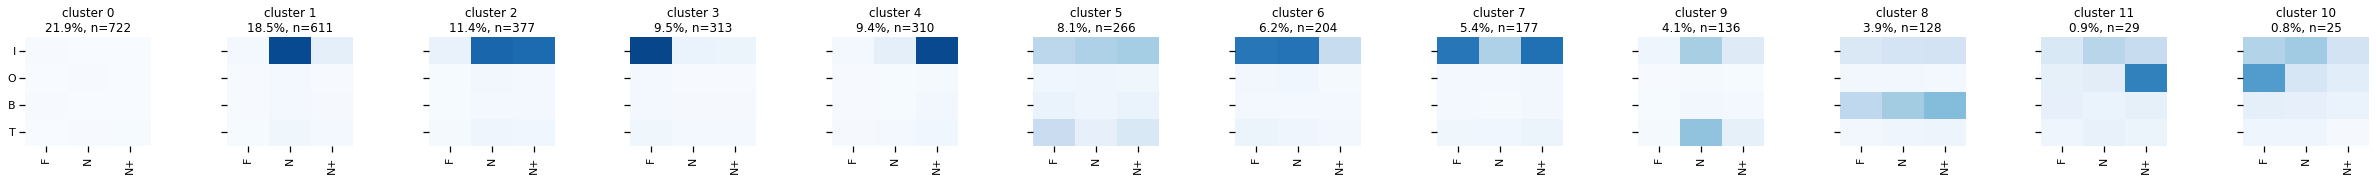

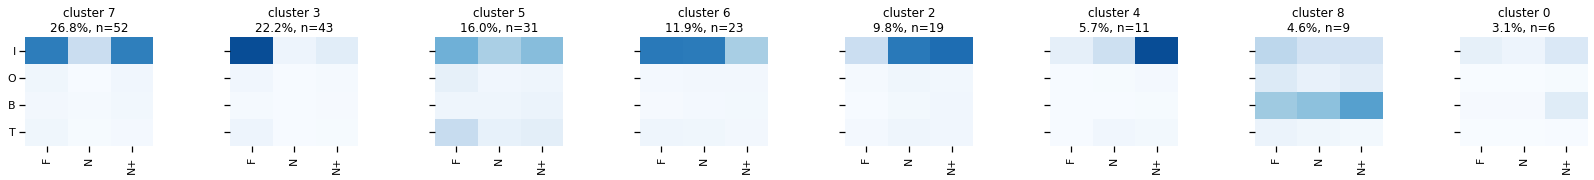

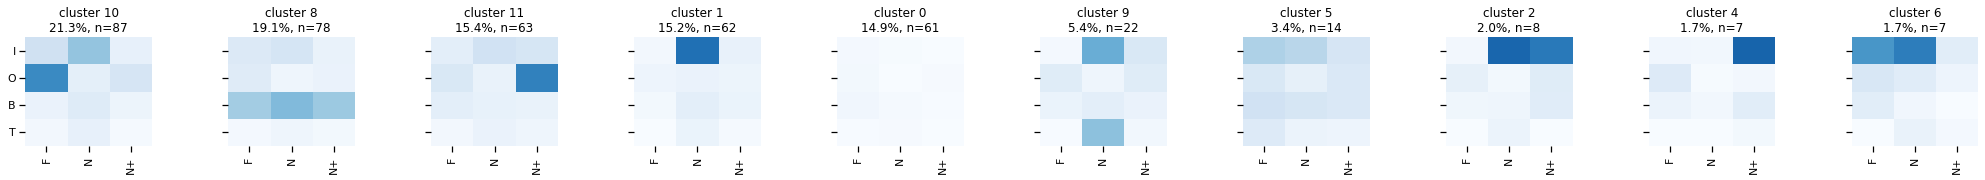

In [ ]:
# plot original clusters

for cre_line in cre_lines:
    feature_matrix_cre = cre_line_dfs[cre_line]
    cluster_df = df_meta[df_meta.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
    vba_clust.plot_clusters_row(cluster_df, feature_matrix_cre, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_original',
                                )


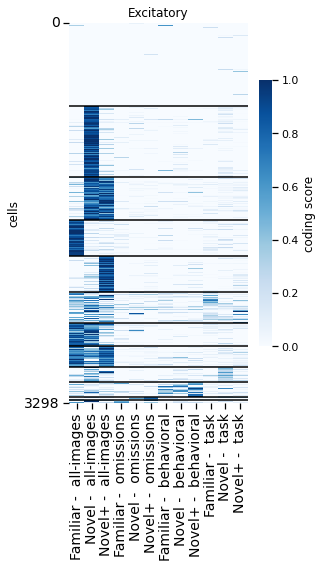

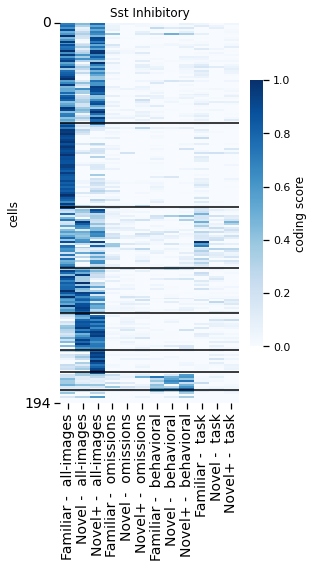

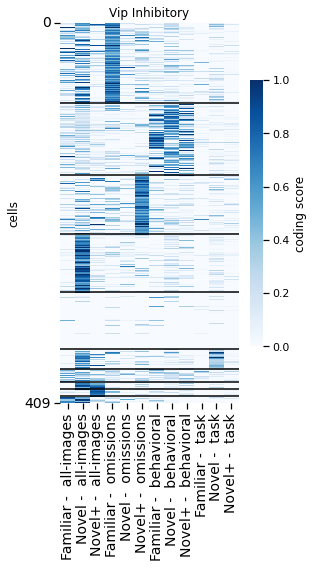

In [28]:
sort_order = {}
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_unraveled_clusters(feature_matrix, cluster_df, sort_order=sort_order, cre_line=cre_line, save_dir=None, folder='', tag='',
                            ax=None, figsize=(4, 7), rename_columns=True)

#### Plot unraveled means by cre line

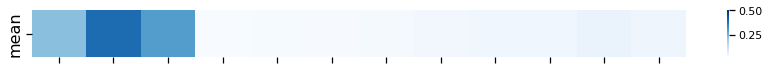

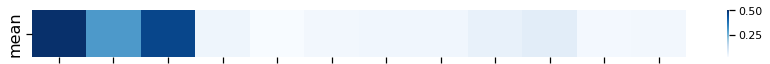

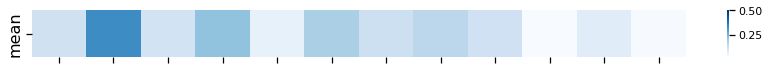

In [29]:
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    data_means = feature_matrix.mean().unstack().loc[['all-images', 'omissions', 'behavioral', 'task']].stack().values
    data_means = np.reshape(data_means, (1,12))
    fig, ax = plt.subplots(1,1,figsize = (12, 1))
    ax = sns.heatmap(data_means, cmap='Blues', vmax=.5, ax=ax)
    ax.set_xticklabels('')
    ax.set_yticklabels(['mean'], fontsize=16)
    plt.tight_layout()
    utils.save_figure(fig, figsize=(12,1), save_dir=save_dir, folder='', 
                      fig_title=f'{cre_line}_mean_unraveled_dropout_scores')

### Plot cluster heatmaps with SSE matrix together

In [30]:
#create unstacked mean dropout scores for each cluster for plotting
cre_original_clusters_unstacked = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df, stacked=False)
  
    cre_original_clusters_unstacked[cre_line] = mean_dropout_scores
            

<AxesSubplot:xlabel='experience_level'>

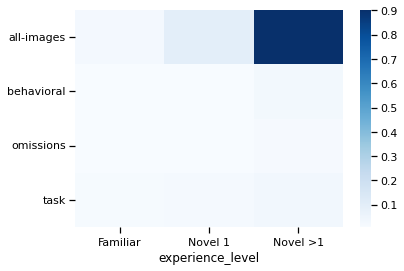

In [31]:
# plot cluster 4 to make sure its correct ('familiar')
sns.heatmap(cre_original_clusters_unstacked[cre_lines[0]][4], cmap='Blues')

### Compute variance

In [32]:
def compute_sse(feature_matrix):
    '''
    Computes Sum of Squared Error between each cell in feature matrix and the mean.
    
    INPUT: 
    feature_matrix (pd.DataFrame) dropout scores, rows are cell specimen ids
    
    Returns:
    SSE (list) of sse values between each cell and their mean.
    '''
    
    N = feature_matrix.shape[0]
    
    mean_values = feature_matrix.mean().values
    
    # SSE = []
    # for i in range(N):
    #     y = feature_matrix.iloc[i].values
    #     SSE.append(np.sum(np.subtract(mean_values,y)**2))
    
    SSE = np.sum(np.subtract(feature_matrix.values, mean_values)**2, axis=1)

    return SSE
    
    

In [33]:
def get_sse_df(feature_matrix, cluster_df, columns = ['cluster_id', 'cre_line'], metric = 'sse'):
    '''
    INPUT:
    feature_matrix:
    cluster_df: (pd.DataFrame) dataframe with columns ['cre_line', 'cluster_id'] and cell specimen id as an index
    metric: (string) 
    
    Returns:
    variability_df
    '''
    
    variability_df = pd.DataFrame(columns=columns)
    cre_lines = vba_clust.get_cre_lines(cluster_df)
    
    columns = [*columns, metric]
    
    if 'cell_specimen_id' in cluster_df.keys():
        cluster_df.set_index('cell_specimen_id', inplace=True)
        
    for cre_line in cre_lines:
        print(cre_line)
        cre_cluster_df = cluster_df[cluster_df.cre_line==cre_line]
        cre_cell_ids = cre_cluster_df.index.values
        cre_feature_matrix = feature_matrix.loc[cre_cell_ids]
        
        cluster_ids = np.sort(cre_cluster_df['cluster_id'].values)
        # compute values for each cluster id
        for cluster_id in cluster_ids:
            cluster_cids = cre_cluster_df[cre_cluster_df.cluster_id==cluster_id].index.values
            cluster_feature_matrix = cre_feature_matrix.loc[cluster_cids]
            if metric is 'sse':
                values = compute_sse(cluster_feature_matrix)
                
                
            variability_df = variability_df.append(pd.DataFrame({'cre_line': [cre_line]*len(values), 
                                   'cluster_id': [cluster_id]*len(values),
                                   metric: values}, index = np.arange(len(values))),
                                                   ignore_index = True)
                                   
            
            
        # compute mean for clustered data
        index = len(variability_df)
        variability_df.at[index,'cre_line'] = cre_line
        variability_df.at[index,'cluster_id'] = 'clustered_mean'
        variability_df.at[index,metric] = variability_df[variability_df.cre_line==cre_line][metric].mean()
        
        # compute mean for unclustered data
        if metric is 'sse':
            value = np.mean(compute_sse(cre_feature_matrix))
        index = len(variability_df)
        variability_df.at[index,'cre_line'] = cre_line
        variability_df.at[index,'cluster_id'] = 'unclustered_mean'
        variability_df.at[index,metric] = value
                
        
    return variability_df
        
            
                
            
        

In [34]:
variability_df = get_sse_df(all_feature_matrix, original_cluster_labels, columns = ['cluster_id', 'cre_line'], metric = 'sse')

Vip-IRES-Cre
Sst-IRES-Cre
Slc17a7-IRES2-Cre


<AxesSubplot:xlabel='cluster_id', ylabel='sse'>

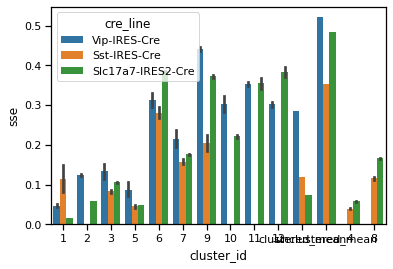

In [35]:
sns.barplot(data = variability_df, x = 'cluster_id', y='sse', hue='cre_line')

In [36]:
def get_sse_df_version2(feature_matrix, cluster_df, columns = ['cluster_id', 'cre_line', 'clustered'], metric = 'sse'):
    '''
    INPUT:
    feature_matrix:
    cluster_df: (pd.DataFrame) dataframe with columns ['cre_line', 'cluster_id'] and cell specimen id as an index
    metric: (string) 
    
    Returns:
    variability_df
    '''
    
    variability_df = pd.DataFrame(columns=columns)
    cre_lines = np.sort(vba_clust.get_cre_lines(cluster_df))
    
    columns = [*columns, metric]
    
    if 'cell_specimen_id' in cluster_df.keys():
        cluster_df.set_index('cell_specimen_id', inplace=True)
        
    for cre_line in cre_lines:
        print(cre_line)
        cre_cluster_df = cluster_df[cluster_df.cre_line==cre_line]
        cre_cell_ids = cre_cluster_df.index.values
        cre_feature_matrix = feature_matrix.loc[cre_cell_ids]
        
        cluster_ids = np.sort(cre_cluster_df['cluster_id'].values)
        # compute values for each cluster id
        for cluster_id in cluster_ids:
            cluster_cids = cre_cluster_df[cre_cluster_df.cluster_id==cluster_id].index.values
            cluster_feature_matrix = cre_feature_matrix.loc[cluster_cids]
            if metric is 'sse':
                values = compute_sse(cluster_feature_matrix)
                
                
            variability_df = variability_df.append(pd.DataFrame({'cre_line': [cre_line]*len(values), 
                                   'cluster_id': [cluster_id]*len(values),
                                    'clustered': [True]*len(values),
                                   metric: values}, index = np.arange(len(values))),
                                                   ignore_index = True)
                                   
            
        if metric is 'sse':
            values = compute_sse(cre_feature_matrix)
        variability_df = variability_df.append(pd.DataFrame({'cre_line': [cre_line]*len(values), 
                                   'cluster_id': [np.nan]*len(values),
                                    'clustered': [False]*len(values),
                                   metric: values}, index = np.arange(len(values))),
                                                   ignore_index = True)
                
        
    return variability_df
        
            
   

In [37]:
variability_df2 = get_sse_df_version2(all_feature_matrix, original_cluster_labels, columns = ['cluster_id', 'cre_line'], metric = 'sse')

Slc17a7-IRES2-Cre
Sst-IRES-Cre
Vip-IRES-Cre


<AxesSubplot:xlabel='clustered', ylabel='sse'>

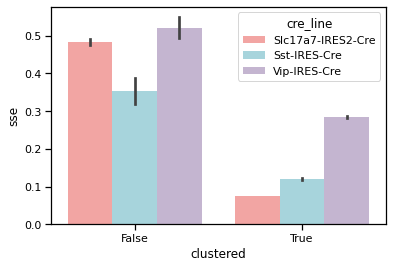

In [38]:
sns.barplot(data = variability_df2, x = 'clustered', y = 'sse', hue = 'cre_line', palette=palette)

<AxesSubplot:xlabel='clustered', ylabel='sse'>

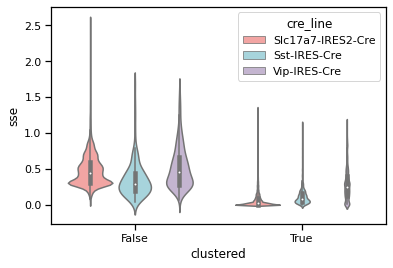

In [39]:
palette = utils.get_cre_line_colors()
sns.violinplot(data = variability_df2, x = 'clustered', y = 'sse', hue = 'cre_line', palette=palette)

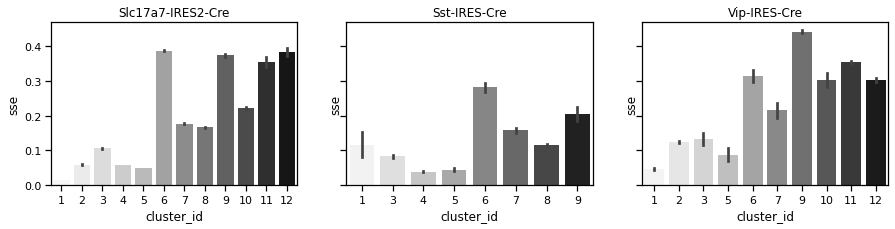

In [40]:
fig, ax = plt.subplots(1,3, figsize = (15,3), sharey=True)
for i,cre_line in enumerate(cre_lines):
    tmp = variability_df2[variability_df2.cre_line==cre_line]
    sns.barplot(data = tmp[tmp.clustered==True], x = 'cluster_id', y = 'sse', palette='Greys',ax=ax[i])
    ax[i].set_title(cre_line)

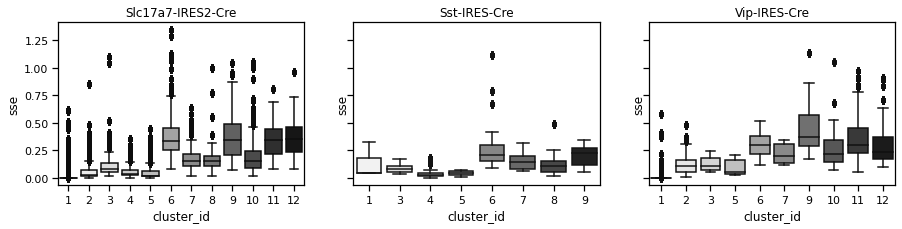

In [41]:
fig, ax = plt.subplots(1,3, figsize = (15,3), sharey = True)
for i,cre_line in enumerate(cre_lines):
    tmp = variability_df2[variability_df2.cre_line==cre_line]
    sns.boxplot(data = tmp[tmp.clustered==True], x = 'cluster_id', y = 'sse', palette='Greys',ax=ax[i])
    ax[i].set_title(cre_line)

### Point plot to show variability

In [42]:
from matplotlib.lines import Line2D
from scipy import stats 


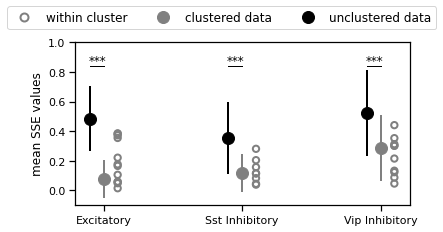

In [43]:

fig, ax = plt.subplots(1,1, figsize = (6,3))
x1 = [0.9, 1.9, 2.9,] # not clustered x location
x2 = [1.1, 2.1, 3.1] # clustered x location
xticklabels = utils.get_cell_types()
labels = [Line2D([0],[0], marker='o', markersize = 8, markerfacecolor='none', markeredgecolor='Grey', markeredgewidth=2, linewidth=0),
        Line2D([0],[0], marker='o', markersize = 12, color='Grey', linewidth=0 ),
         Line2D([0],[0], marker='o', markersize=12, color='Black', linewidth=0)]
for c, cre_line in enumerate(cre_lines):
    cre_tmp = variability_df2[(variability_df2.cre_line==cre_line)]
    # plot clusters means
    cluster_tmp = cre_tmp[cre_tmp.clustered==True]
    y = cluster_tmp.groupby('cluster_id').mean().values
    x = [x2[c]]*len(y)
    ax.scatter(x=x,y=y,marker = 'o', s=40, facecolors='none', edgecolors='Grey',linewidth=2)
    
    # plot clustered mean
    x = x2[c]
    y = cluster_tmp['sse'].mean()
    err = cluster_tmp['sse'].std()
    ax.errorbar(x=x-0.1,y=y,yerr=err, marker='o', markersize = 12, color='Grey', linewidth=2)

    # plot not clustered mean
    x=x1[c]
    y = cre_tmp[(cre_tmp.clustered==False)]['sse'].mean()
    err = cre_tmp[(cre_tmp.clustered==False)]['sse'].std()
    ax.errorbar(x=x,y=y,yerr=err, marker='o', markersize=12, color='Black', linewidth=2)
    
    # add significance stars
    ax.text(x1[c]-0.01, 0.85, s='***', fontsize=12, color='Black')
    ax.plot([x1[c], x2[c]-0.1], [0.84, 0.84], color='Black', linewidth=1)
ax.set_xticks([1,2,3])
ax.set_xticklabels(xticklabels)
ax.set_ylabel('mean SSE values')
ax.set_ylim([-0.1, 1])

ax.legend(labels, ['within cluster', 'clustered data', 'unclustered data'],
          loc="center right", 
    ncol=3,
    bbox_to_anchor=[1.08, 1.15],
    borderaxespad=0, fontsize = 12)

utils.save_figure(fig, figsize = (6,3), save_dir=save_dir, folder='', fig_title = 'Reduction_in_variability')

In [44]:
cre_lines = np.sort(variability_df2.cre_line.unique())

In [45]:
for cre_line in cre_lines:
    tmp = variability_df2[variability_df2.cre_line==cre_line]
    a = tmp[tmp.clustered==False]['sse'].mean()
    b = tmp[tmp.clustered==True]['sse'].mean()
    
    c = (a-b)/a
    print(cre_line)
    print(a,b,c)
    

Slc17a7-IRES2-Cre
0.4837647945705629 0.07513532408402329 0.844686250576128
Sst-IRES-Cre
0.3530089713394021 0.11963647834504283 0.6610950767310166
Vip-IRES-Cre
0.5206075517613376 0.2853414938251932 0.45190673308557294


In [46]:
for cre_line in cre_lines:
    tmp = variability_df2[variability_df2.cre_line==cre_line]
    a = tmp[tmp.clustered==False]['sse'].mean()
    b = tmp[tmp.clustered==True].groupby('cluster_id').mean()['sse'].mean()
    c = (a-b)/a
    print(cre_line)
    print(a,b,c)
    

Slc17a7-IRES2-Cre
0.4837647945705629 0.19540126678328815 0.5960820858062945
Sst-IRES-Cre
0.3530089713394021 0.13011195814340473 0.6314202507383078
Vip-IRES-Cre
0.5206075517613376 0.2315229264845356 0.5552831961402803


#### Compare cre line variance only


In [47]:
tmp = variability_df2[(variability_df2.clustered==False)]

In [48]:
SSE = []
for c, cre_line in enumerate(cre_lines):
    SSE.append(tmp[tmp.cre_line==cre_line]['sse'].values)

#### Statistics

In [49]:
from scipy.stats import ranksums
from scipy.stats import f_oneway

In [50]:
print('one way anova to test cre line variability')
f_oneway(SSE[0], SSE[1], SSE[2])

one way anova to test cre line variability


F_onewayResult(statistic=36.286793386753345, pvalue=2.430822503599902e-16)

In [51]:
print('Slc and SST: ', ranksums(SSE[0], SSE[1]))
print('SST and VIP: ', ranksums(SSE[1], SSE[2]))
print('Slc and VIP: ', ranksums(SSE[0], SSE[2]))

Slc and SST:  RanksumsResult(statistic=9.903914815055623, pvalue=4.0029196644519667e-23)
SST and VIP:  RanksumsResult(statistic=-7.748557219285197, pvalue=9.294248848129635e-15)
Slc and VIP:  RanksumsResult(statistic=-0.07714616445986061, pvalue=0.9385072684730377)


#### Plot cre line differences

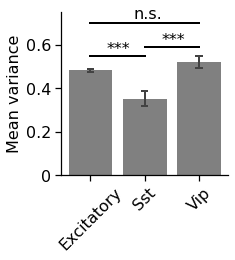

In [52]:
fig, ax = plt.subplots(1,1, figsize = (3,3))
tmp = variability_df2[(variability_df2.clustered==False)]
# ax = sns.pointplot(data=tmp, x = 'cre_line', 
#               y='sse', join=False, color='Black', 
#                    scale=1.8, errwidth=2,capsize=0.1,
#                    ax=ax)
ax = sns.barplot(data=tmp, x = 'cre_line', 
              y='sse',  color='Grey', 
                    errwidth=2,capsize=0.1,
                   ax=ax)
ax.set_xticklabels(['Excitatory', 'Sst', 'Vip'], rotation=45, fontsize=16)
ax.set_xlabel('')
ax.set_ylim([0,0.75])
yticks = [0, 0.2, 0.4, 0.6]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=16)
ax.set_ylabel('Mean variance', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# add significance stars
ax.text(0.3, 0.56, s='***', fontsize=16, color='Black')
ax.plot([0, 1], [0.55, 0.55], color='Black', linewidth=2)

ax.text(1.3, 0.6, s='***', fontsize=16, color='Black')
ax.plot([1, 2], [0.59, 0.59], color='Black', linewidth=2)

ax.text(0.8, 0.72, s='n.s.', fontsize=16, color='Black')
ax.plot([0, 2], [0.7, 0.7], color='Black', linewidth=2)
utils.save_figure(fig, figsize = (3,3), save_dir=save_dir, folder='', fig_title = 'Mean_variability_by_cell_type')

#### post clustering statistics

In [53]:
for c, cre_line in enumerate(cre_lines):
    cre_tmp = variability_df2[(variability_df2.cre_line==cre_line)]
    print(ranksums(cre_tmp[cre_tmp.clustered==True]['sse'].values, cre_tmp[cre_tmp.clustered==False]['sse'].values))

RanksumsResult(statistic=-92.3673680062883, pvalue=0.0)
RanksumsResult(statistic=-17.799495178732016, pvalue=7.1308755558249324e-71)
RanksumsResult(statistic=-17.523968962937865, pvalue=9.403068499336643e-69)


### Cluster size plots

In [54]:
for c, cre_line in enumerate(cre_lines):
    cre_tmp = original_cluster_labels[(original_cluster_labels.cre_line==cre_line)]

In [55]:
normalized_values = original_cluster_labels.groupby('cre_line')['cluster_id'].value_counts(normalize=True).values

In [56]:
grouped_df = original_cluster_labels.groupby(['cre_line','cluster_id']).count().reset_index()

In [57]:
grouped_df['normalized'] = normalized_values
grouped_df['percentage'] = grouped_df['normalized'] *100

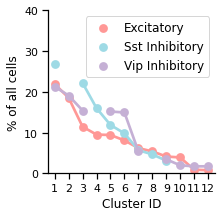

In [58]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
markersize = [14, 10, 10]
linewidth = [4, 2, 2]
ax=sns.pointplot(data = grouped_df, x = 'cluster_id', y = 'percentage',
              hue= 'cre_line', palette = palette,joinlinewidth=0.1,ax=ax)
ax.legend(ax.get_legend_handles_labels()[0],utils.get_cell_types(), fontsize=12)
ax.set_ylim([0,40])
ax.set_xlabel('Cluster ID')
ax.set_ylabel('% of all cells')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
utils.save_figure(fig, figsize = (3,3), save_dir=save_dir, folder='', fig_title = 'Cluster_sizes_cre')

In [59]:
labels_cre = {}
for cre_line in cre_lines:
    labels_cre[cre_line] = original_cluster_labels[original_cluster_labels.cre_line==cre_line]['cluster_id'].values

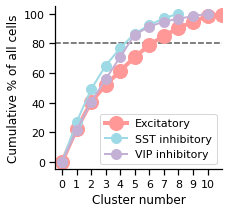

In [60]:
fig, ax = plt.subplots(1,1, figsize = (3,3))
ax = vba_clust.plot_N_clusters_by_cre_line(labels_cre, ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
utils.save_figure(fig, figsize = (3,3), save_dir=save_dir, folder='', fig_title = 'Cumulative_cluster_sizes_cre')

#### Pie chart plots

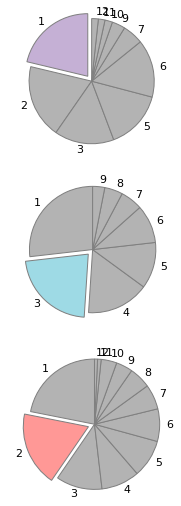

In [61]:
explode_index = [0,1,1]

fig, ax = plt.subplots(3,1, figsize = (3, 9))
for c, cre_line in enumerate(cre_lines[::-1]):
    cluster_ids = grouped_df[grouped_df.cre_line==cre_line]['cluster_id'].values
    cluster_id_labels = [str(cluster_id) for cluster_id in cluster_ids]
    sizes = grouped_df[grouped_df.cre_line==cre_line]['percentage'].values
    explode = [0]*len(cluster_ids)
    explode[explode_index[c]] = 0.1
    colors = [(0.7, 0.7, 0.7)]*len(cluster_ids)
    colors[explode_index[c]] = palette[::-1][c]
    pie = ax[c].pie(sizes, explode=explode, labels=cluster_id_labels, colors = colors,startangle=90)
    for w in pie[0]:
        w.set_linewidth(1)
        w.set_edgecolor('Grey')

    ax[c].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
utils.save_figure(fig, figsize = (3, 9), save_dir=save_dir, folder='', fig_title = 'pie_chart_cluster_size')

## Mean image responses for disinhibitory circuit example

### Optimal k

In [62]:
from sklearn.cluster import SpectralClustering
import pickle 

In [67]:
n_clusters = {'all': 12}

In [66]:
distance_metrics = ['euclidean']
shuffle_type = 'all'

for metric in distance_metrics:
    gap_filename = os.path.join(base_dir, 'gap_scores_{}_{}_nb20_{}.pkl'.format(metric, glm_version, shuffle_type))
    if os.path.exists(gap_filename):
        with open(gap_filename, 'rb') as f:
            gap_df = pickle.load(f)
            f.close()
        print('file exists...')
    else:
        gap_df = {}
        df = all_feature_matrix
        sc = SpectralClustering()
        gap_statistics = vba_clust.compute_gap(sc, df, k_max = 25, reference_shuffle=shuffle_type, metric=metric)
        
        vba_clust.save_clustering_results(gap_statistics, gap_filename)

shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling al

In [101]:
sc = SpectralClustering(n_clusters=12)
sc.fit(X )
A = sc.affinity_matrix_

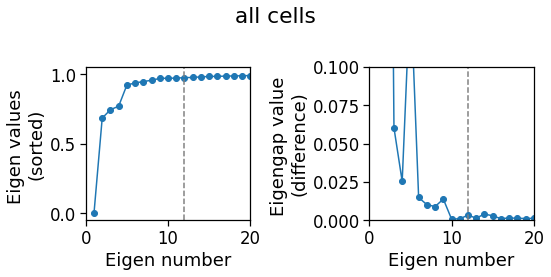

In [106]:
eigenvalues_cre = {}
eigenvalues, eigenvectors, nb_clusters = vba_clust.get_eigenDecomposition(A, max_n_clusters=25)
eigenvalues_cre['all'] = eigenvalues
vba_clust.plot_eigengap_values(eigenvalues_cre, ['all'], n_clusters_cre={'all':12}, save_dir=base_dir, folder='eigengap')


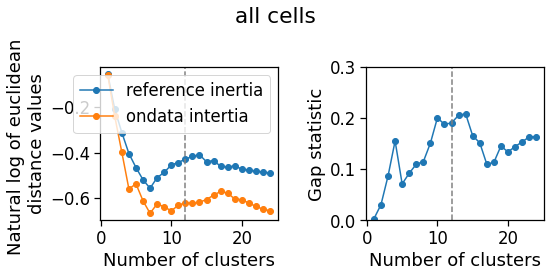

In [107]:
gap_df['all'] = gap_statistics
vba_clust.plot_gap_statistic(gap_statistic=gap_df, cre_lines=['all'], n_clusters_cre={'all':12},
                   tag='12', save_dir=base_dir, folder='gap_statistic')

### Plot coclustering matrix

In [92]:
filename = os.path.join(base_dir, '24_events_all_L2_optimize_by_session_coClustering_matrix.pkl')
if os.path.exists(filename):
    print('loading file...')
    with open(filename, 'rb') as f:
        coclustering_matrices  = pkl.load(f)
        f.close()
        print('done.')
else:
    cre_line='all'
    coclustering_matrices = {}
    X = all_feature_matrix.values
    m = vba_clust.get_coClust_matrix(X,n_clusters=12, nboot=np.arange(100))
    coclustering_matrices[cre_line]=pd.DataFrame(data=m, index=all_feature_matrix.index.values, columns = [all_feature_matrix.index.values])
    vba_clust.save_clustering_results(coclustering_matrices, filename)
    

loading file...
done.


In [93]:
coclustering_matrices[cre_line]=pd.DataFrame(data=m, index=all_feature_matrix.index.values, columns = [all_feature_matrix.index.values])
vba_clust.save_clustering_results(coclustering_matrices, filename)

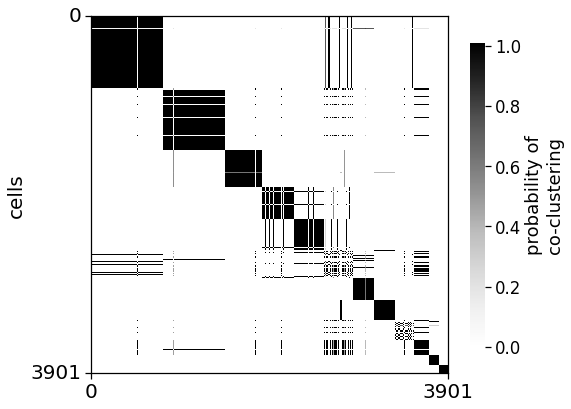

In [95]:

for cre_line in ['all']:
    vba_clust.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_matrices, original_cluster_labels,
                                                              cre_line, base_dir, folder='coClust_matrix')

In [21]:
data_type = 'filtered_events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'platform_experiment_table'

# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted']

# suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

all_images_mdf = multi_session_df[multi_session_df.omitted==False]

there are 1249 experiments in the full multi_session_df
getting experiment table for March and August releases from lims
excluding Ai94 data
there are 402 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


In [22]:
omission_mdf= multi_session_df[multi_session_df.omitted==True]

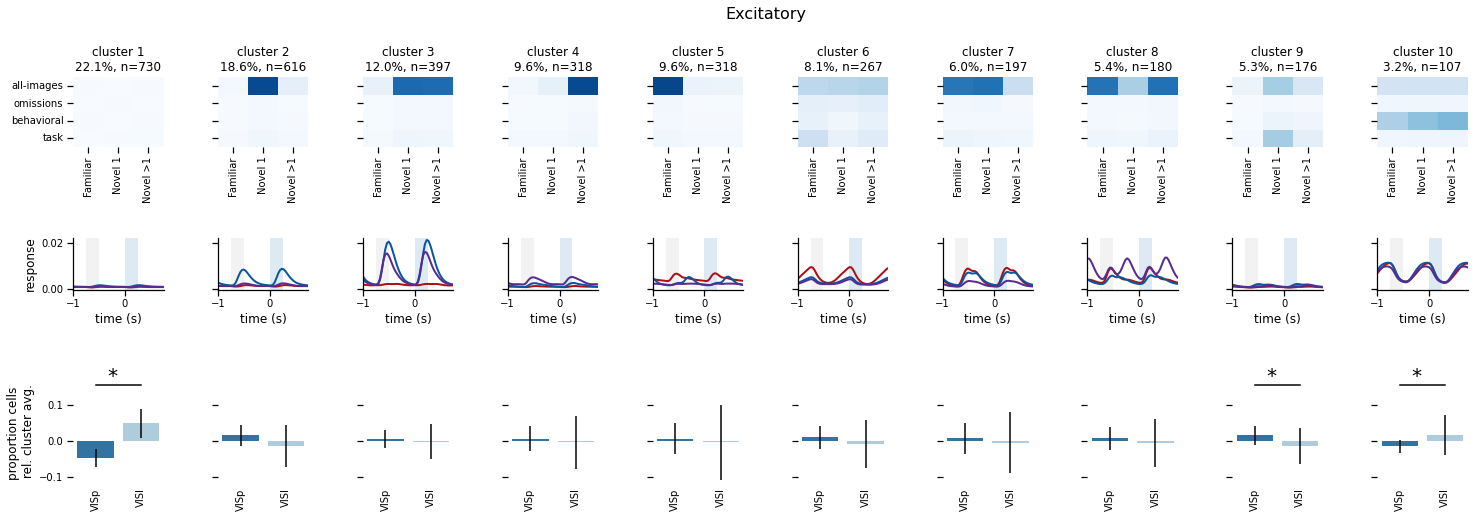

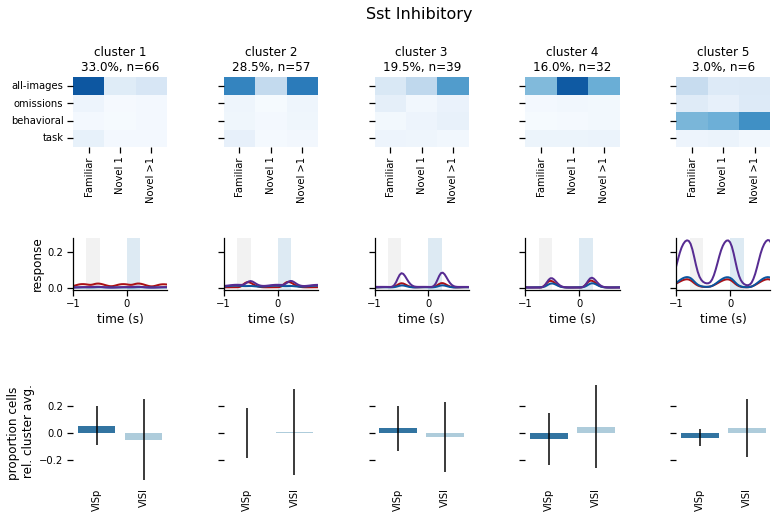

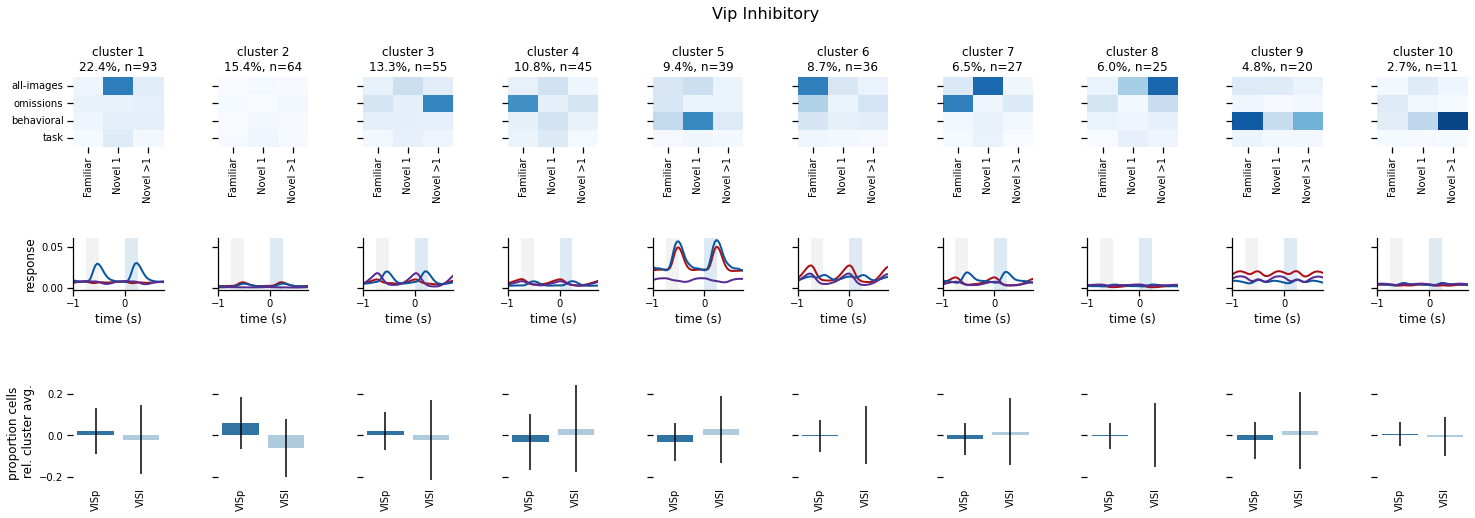

In [72]:
# this plot doesnt work without multi_session_df
folder = 'targeted_structure'
for cre_line in cre_lines:
    vba_clust.plot_clusters_stats_pop_avg_rows(df_meta, cre_line_dfs[cre_line], multi_session_df=all_images_mdf, cre_line = cre_line,
                                     columns_to_groupby=[folder], change=True, omitted=False,
                                     sort_order=None, save_dir=save_dir, folder=folder, suffix='_changes', alpha=0.05)


### Plot mean traces for example disinhibitory circuit

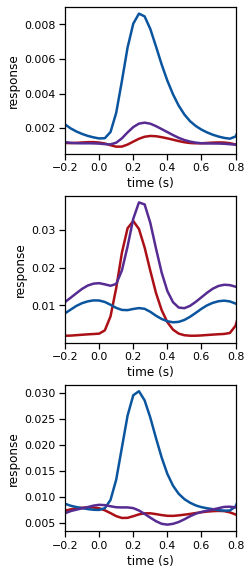

In [73]:
cluster_ids_sel = [2,2,1]
fig, ax = plt.subplots(3,1, figsize=(3,9))
colors = utils.get_experience_level_colors()
for c, cre_line in enumerate(cre_lines):
    ts = all_images_mdf.trace_timestamps.iloc[0]
    cids = df_meta[(df_meta.cre_line==cre_line) & (df_meta.cluster_id==cluster_ids_sel[c])].index.values
    sel_df = all_images_mdf[all_images_mdf.cell_specimen_id.isin(cids)][['mean_trace', 'experience_level']]
    experience_levels = np.sort(sel_df.experience_level.unique())
    for e,exp in enumerate(experience_levels):
        exp_df = sel_df[sel_df.experience_level==exp]
        ax[c].plot(ts,exp_df.mean_trace.mean(), color=colors[e], linewidth = 2.5)
    ax[c].set_xlim([-0.2,0.8])
    ax[c].set_xlabel('time (s)')
    ax[c].set_ylabel('response')
plt.tight_layout()
utils.save_figure(fig, save_dir=save_dir, folder='', figsize=(4,8), fig_title='mean_responses_disinhibitory_circuit_v2')
    

### Proportions of clusters by area and depth

In [23]:
cluster_meta = vba_clust.add_location_column(df_meta)

In [24]:
cluster_meta.head()

,cluster_id,labels,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,...,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure,original_cluster_id,within_cluster_correlation,location
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
1086492406,3,3,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,3,0.774625,VISp_upper
1086492307,2,2,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,2,0.378218,VISp_upper
1086492221,4,4,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,4,0.795968,VISp_upper
1086492174,4,4,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,4,0.832309,VISp_upper
1086491936,2,2,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,2,0.378218,VISp_upper


In [49]:
areas = np.sort(cluster_meta['location'].unique())[::-1]

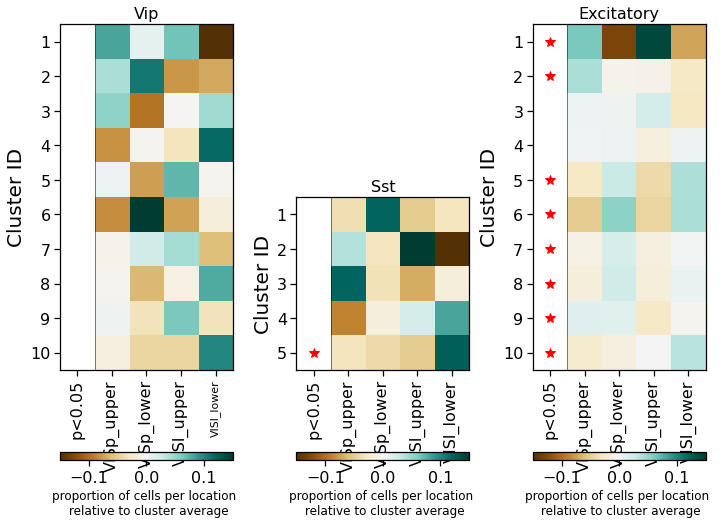

In [75]:
glm_clust.plot_cluster_proportions(cluster_meta.reset_index(), areas=areas)

## Single cell example

In [77]:
import visual_behavior.visualization.ophys.platform_single_cell_examples as psc

ModuleNotFoundError: No module named 'mindscope_utilities'

In [ ]:
results_pivoted, weights_df, kernels = processing.load_GLM_outputs(glm_version, glm_output_dir)

In [ ]:
cells_table = loading.get_cell_table()
experiments_table = loading.get_platform_paper_experiment_table(add_extra_columns=True, limit_to_closest_active=True)
tmp = cluster_ids.merge(cells_table, on=['cre_line', 'cell_specimen_id'], how='left').drop_duplicates(subset='cell_specimen_id')
container_data = tmp[tmp.ophys_container_id == ophys_container_id]

In [ ]:
container_csids = container_data.cell_specimen_id.unique()
dropout_features = ['all-images', 'omissions', 'behavioral', 'task']


In [ ]:

psc.plot_cell_rois_and_GLM_weights(cell_specimen_id, cells_table, experiments_table, dropout_features,
                                               results_pivoted, weights_df, weights_features, kernels,
                                               save_dir, folder, data_type)

In [ ]:

for cre_line in cre_lines:
    # Calculate unique mouse IDs in each cluster
    tmp = cluster_df[cluster_df.cre_line_x==cre_line]
    unique_mouse_per_cluster = tmp.groupby('cluster_id')['mouse_id'].nunique()

    # Calculate unique cluster IDs in each mouse
    unique_cluster_per_mouse = tmp.groupby('mouse_id')['cluster_id'].nunique()
    
    figsize=(5,7)
    fig, ax = plt.subplots(2,1, figsize = figsize)
    unique_mouse_per_cluster.plot(kind='bar', color='grey', ax =ax[0])
    ax[0].set_xlabel('cluster ID')
    ax[0].set_ylabel('Number of mice')
    ax[0].set_yticks(np.round(ax[0].get_yticks(),1))
    ax[0].set_title(vba_clust.get_cre_line_map(cre_line))
    
    unique_cluster_per_mouse.plot(kind='bar', color='grey', ax =ax[1], fontsize=10)

    ax[1].set_ylabel('Number of unique \ncluster IDs')
    ax[1].set_yticks(np.round(ax[1].get_yticks(),1))
    ax[1].set_xlabel('Animal ID')

    plt.tight_layout()
    fig_title = f'mouse_id_cluster_id_control_{cre_line}'
    utils.save_figure(fig, figsize, save_dir=base_dir, folder = 'cluster_control_supp_fig', fig_title=fig_title, formats=['.png', '.pdf'])